In [2]:
from plotnine import *
import pandas as pd

In [3]:
# Load the dataset
file_path = './data/combined.csv'
data = pd.read_csv(file_path, skipinitialspace=True)

data.head()

,arch,item_size,runlength,scheme,time,cycle,kcycles,instr,L1-miss,LLC-miss,br-miss,task,scale,IPC,CPU,GHz
0,x86,4194304,64,naive,0.01,6.13,4.13,7.98,0.0,0.0,0.01,1.50,4194304,1.30,1.05,4.08
1,x86,4194304,64,naive,0.00,1.39,0.06,4.26,0.0,0.0,0.01,0.44,4194304,3.07,1.13,3.13
2,x86,4194304,64,naive,0.00,1.30,0.05,4.26,0.0,0.0,0.01,0.40,4194304,3.27,1.19,3.24
3,x86,4194304,64,comp_intrin_128,0.00,0.59,0.04,1.24,0.0,0.0,0.01,0.23,4194304,2.09,1.38,2.56
4,x86,4194304,64,comp_intrin_128,0.00,0.62,0.04,1.24,0.0,0.0,0.01,0.21,4194304,2.01,1.39,2.92


In [4]:
# Checking column names and data types
column_info = data.dtypes

data.columns, data["item_size"].min()

(Index(['arch', 'item_size', 'runlength', 'scheme', 'time', 'cycle', 'kcycles',
        'instr', 'L1-miss', 'LLC-miss', 'br-miss', 'task', 'scale', 'IPC',
        'CPU', 'GHz'],
       dtype='object'),
 4194304)

In [5]:
grouped_data = data.groupby(['arch', 'item_size', 'runlength', 'scheme']).nth(1).reset_index()
naive_data = grouped_data[grouped_data['scheme'] == 'naive']

grouped_data.head()

,index,arch,item_size,runlength,scheme,time,cycle,kcycles,instr,L1-miss,LLC-miss,br-miss,task,scale,IPC,CPU,GHz
0,1,x86,4194304,64,naive,0.0,1.39,0.06,4.26,0.0,0.0,0.01,0.44,4194304,3.07,1.13,3.13
1,4,x86,4194304,64,comp_intrin_128,0.0,0.62,0.04,1.24,0.0,0.0,0.01,0.21,4194304,2.01,1.39,2.92
2,7,x86,4194304,64,comp_intrin_256,0.0,0.64,0.06,0.75,0.0,0.0,0.01,0.24,4194304,1.17,1.34,2.70
3,10,x86,4194304,64,avx2,0.0,0.66,0.05,0.75,0.0,0.0,0.01,0.23,4194304,1.13,1.38,2.92
4,13,x86,4194304,64,comp_intrin_512,0.0,0.68,0.04,0.50,0.0,0.0,0.01,0.23,4194304,0.74,1.35,2.96


# SPEEDUP TO NAIVE IMPLEMENTATION

In [8]:
# Function to calculate speedup
def calculate_speedup(row, naive_data):
    # Find the corresponding naive time
    naive_time = naive_data[(naive_data['arch'] == row['arch']) &
                            (naive_data['item_size'] == row['item_size']) &
                            (naive_data['runlength'] == row['runlength'])]['time'].values[0]
    # Avoid division by zero
    # TODO: HOW TO CALCULATE SPEEDUP? 
    if naive_time > 0:
        return naive_time / row['time']
    else:
        return None
    
grouped_data['speedup'] = grouped_data.apply(calculate_speedup, naive_data=naive_data, axis=1)

/tmp/ipykernel_4635/2484800015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/kosakseb/.local/lib/python3.10/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


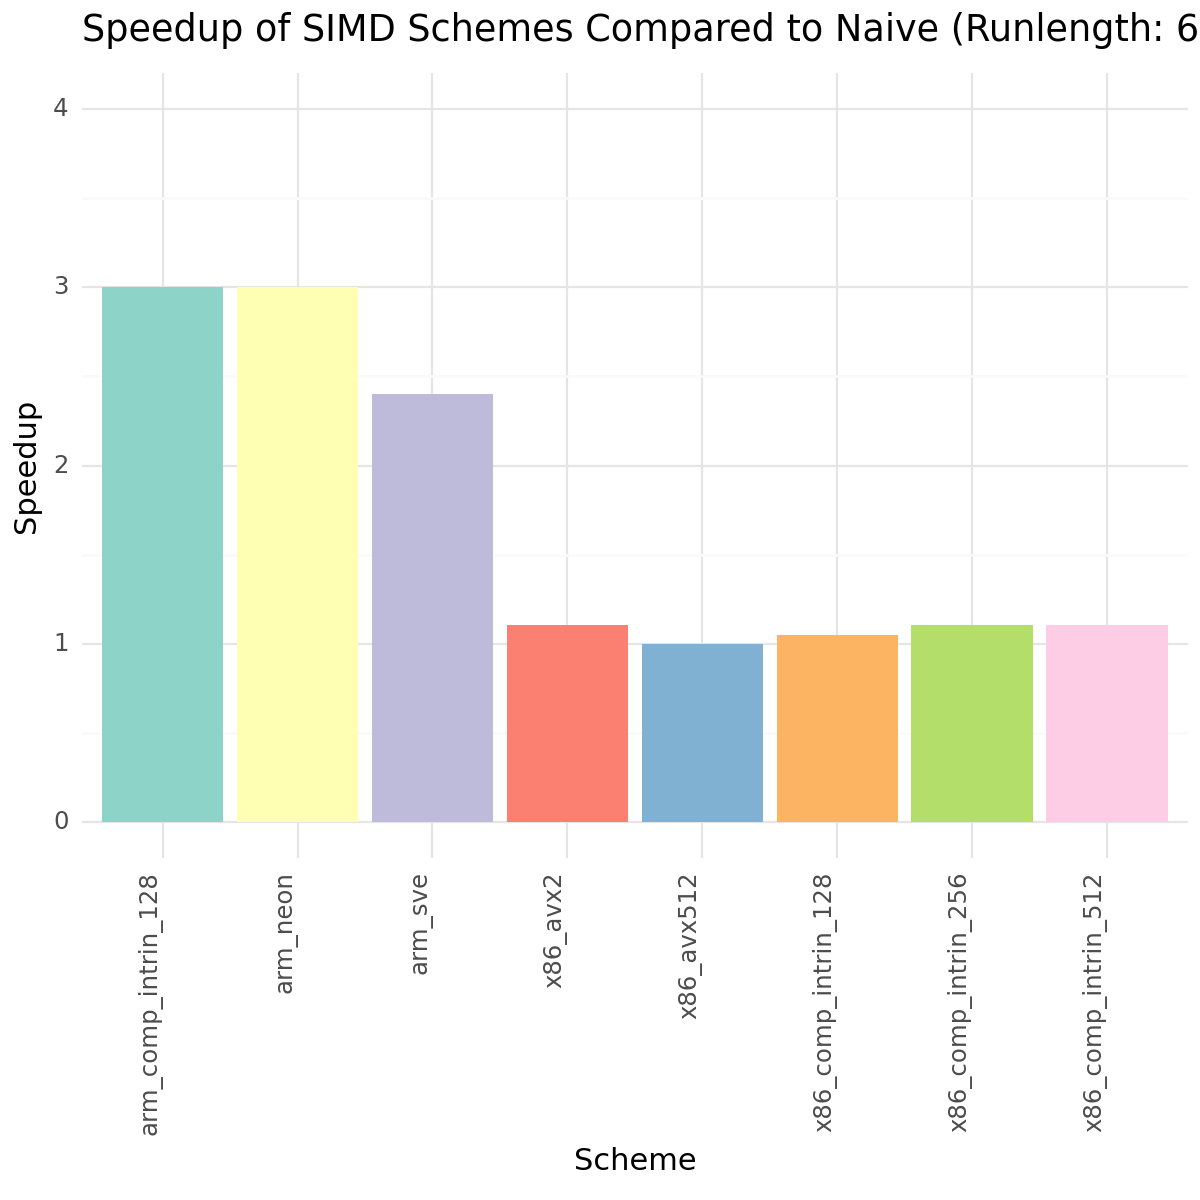

/home/kosakseb/.local/lib/python3.10/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


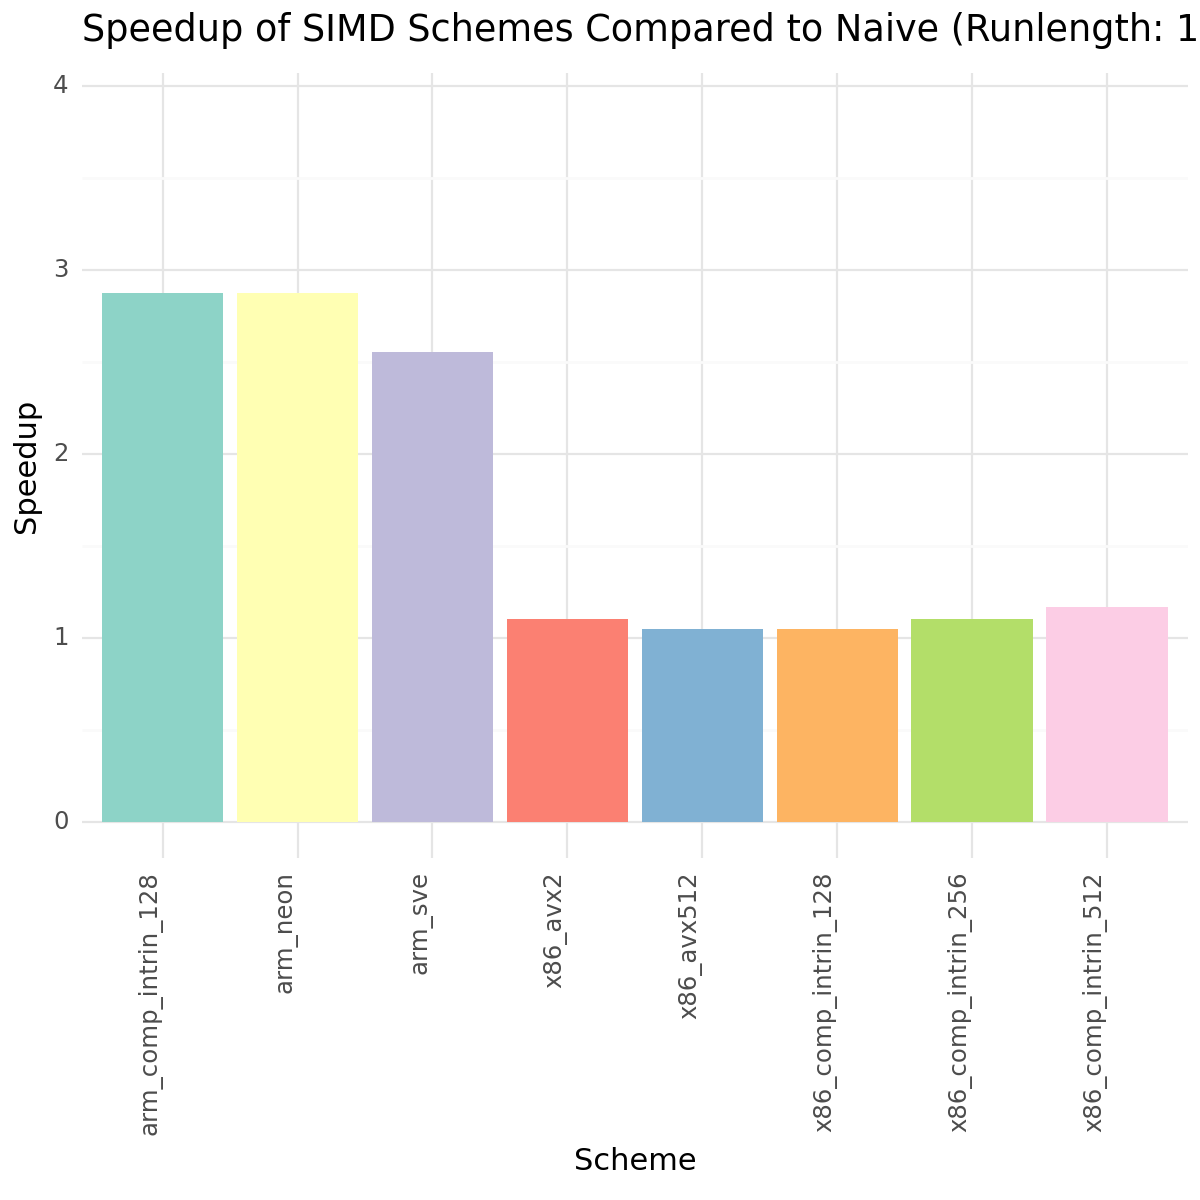

/home/kosakseb/.local/lib/python3.10/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


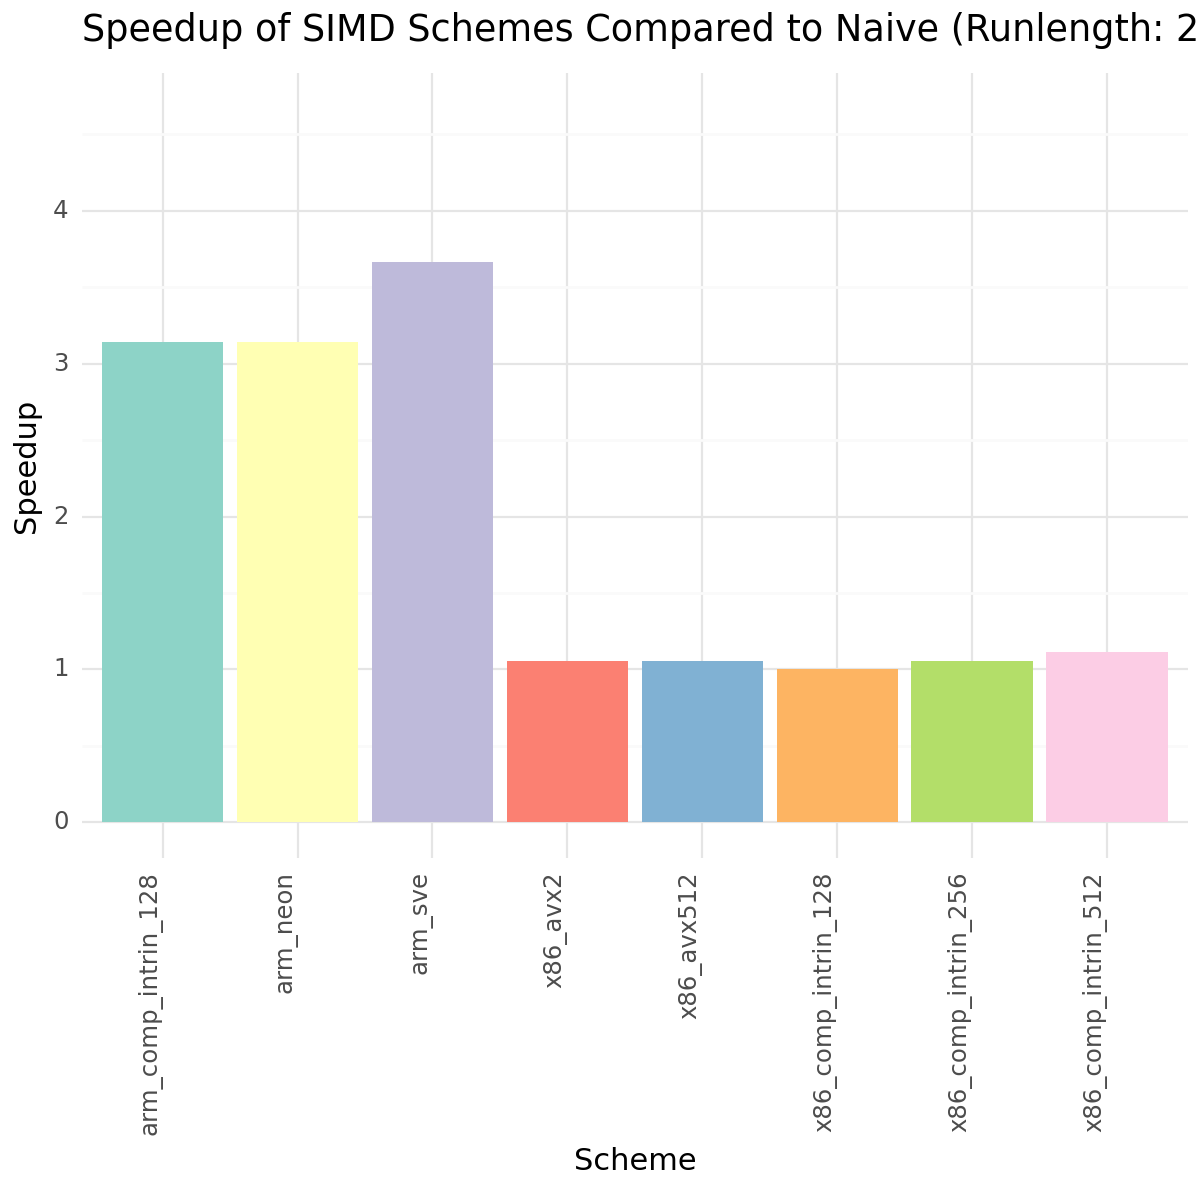

[<Figure Size: (600 x 600)>,
 <Figure Size: (600 x 600)>,
 <Figure Size: (600 x 600)>]

In [60]:
final_data = grouped_data[(grouped_data['scheme'] != 'naive') & (grouped_data['item_size'] == data["item_size"].max())]
final_data['arch_scheme'] = final_data['arch'].astype(str) + '_' + final_data['scheme'].astype(str)

# Generate plots for each runlength
plots = []
for runlength in final_data['runlength'].unique():
    plot_data = final_data[final_data['runlength'] == runlength]
    plot = (ggplot(plot_data, aes(x='arch_scheme', y='speedup', fill='arch_scheme')) +
            geom_bar(stat="identity", position='dodge') +
            scale_fill_brewer(type='qual', palette='Set3') +
            ggtitle(f"Speedup of SIMD Schemes Compared to Naive (Runlength: {runlength})") +
            xlab("Scheme") +
            ylab("Speedup") +
            theme_minimal() +
            theme(figure_size=(6, 6), subplots_adjust={'right': 0.85}) +   # Adjusting plot size and right margin
            theme(legend_position='none') +   # Hides the legend
            theme(axis_text_x=element_text(angle=90, hjust=1)) + 
            ylim(0, max(plot_data['speedup'].dropna()) + 1))

    plots.append(plot)

# Displaying the first plot as an example
plots

# CYCLE / INSTRUCTION PER CYCLE

In [49]:
def create_ggplot_scatter_with_labels(data, x_axis, y_axis, category, split_by):
    unique_values = data[split_by].unique()
    plots = []

    for value in unique_values:
        # Filter data for each unique value in split_by column
        subset_data = data[data[split_by] == value]

        # Create scatter plot with labels
        plot = (
            ggplot(subset_data, aes(x=x_axis, y=y_axis, color=category, label=category)) 
            + scale_x_continuous(limits=(0, data[x_axis].max() + 0.5))  # Adjust as needed
            + scale_y_continuous(limits=(0, data[y_axis].max() + 0.5))  # Adjust as needed
            + geom_point() 
            + geom_text(nudge_y=0.03, nudge_x=-0.2, ha='left', va='bottom')
            + theme_minimal()
            + theme(figure_size=(6, 6), subplots_adjust={'right': 0.85})  # Adjusting plot size and right margin
            + scale_color_discrete(guide=False)
            + labs(title=f'Scatter Plot of {x_axis} vs {y_axis} for {split_by} = {value}', x=x_axis, y=y_axis)
        )
        plots.append(plot)

    return plots

/tmp/ipykernel_4635/726594389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/kosakseb/.local/lib/python3.10/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


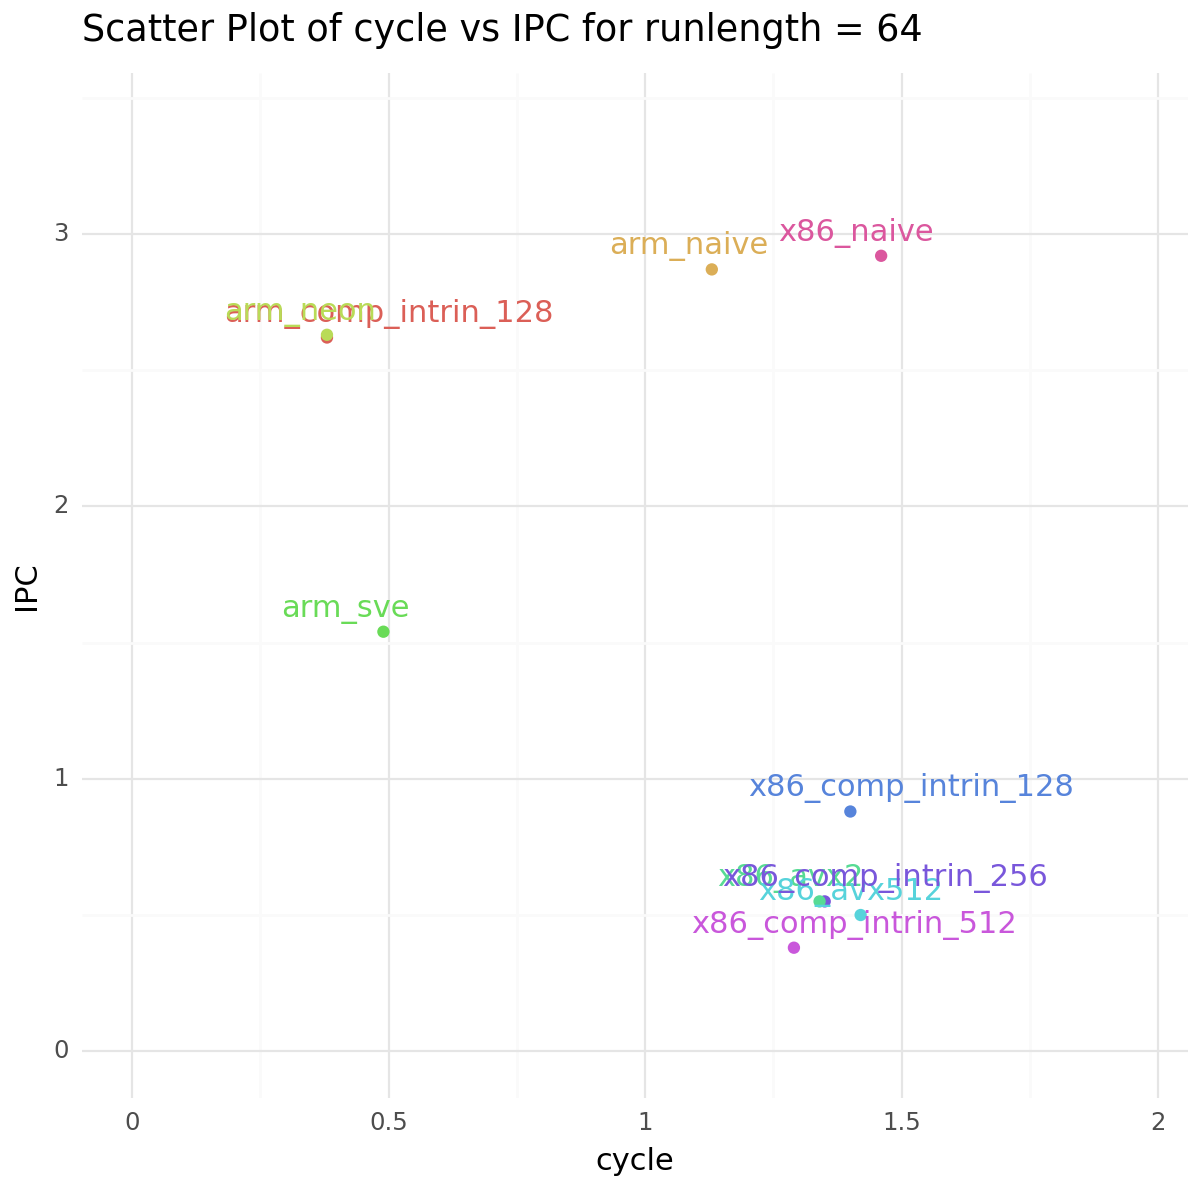

/home/kosakseb/.local/lib/python3.10/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


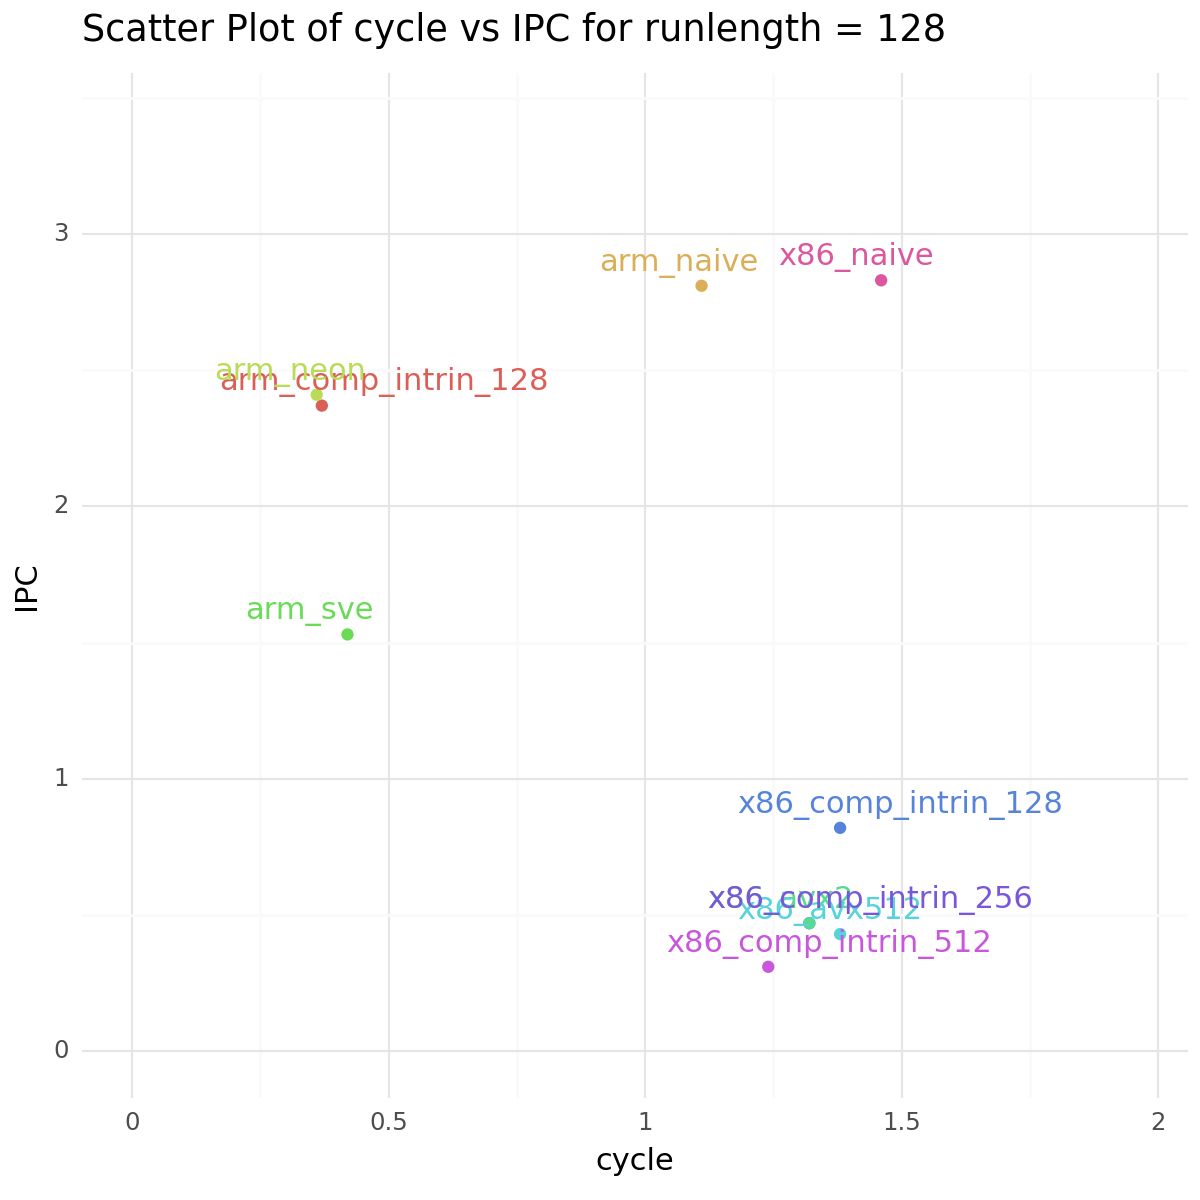

/home/kosakseb/.local/lib/python3.10/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


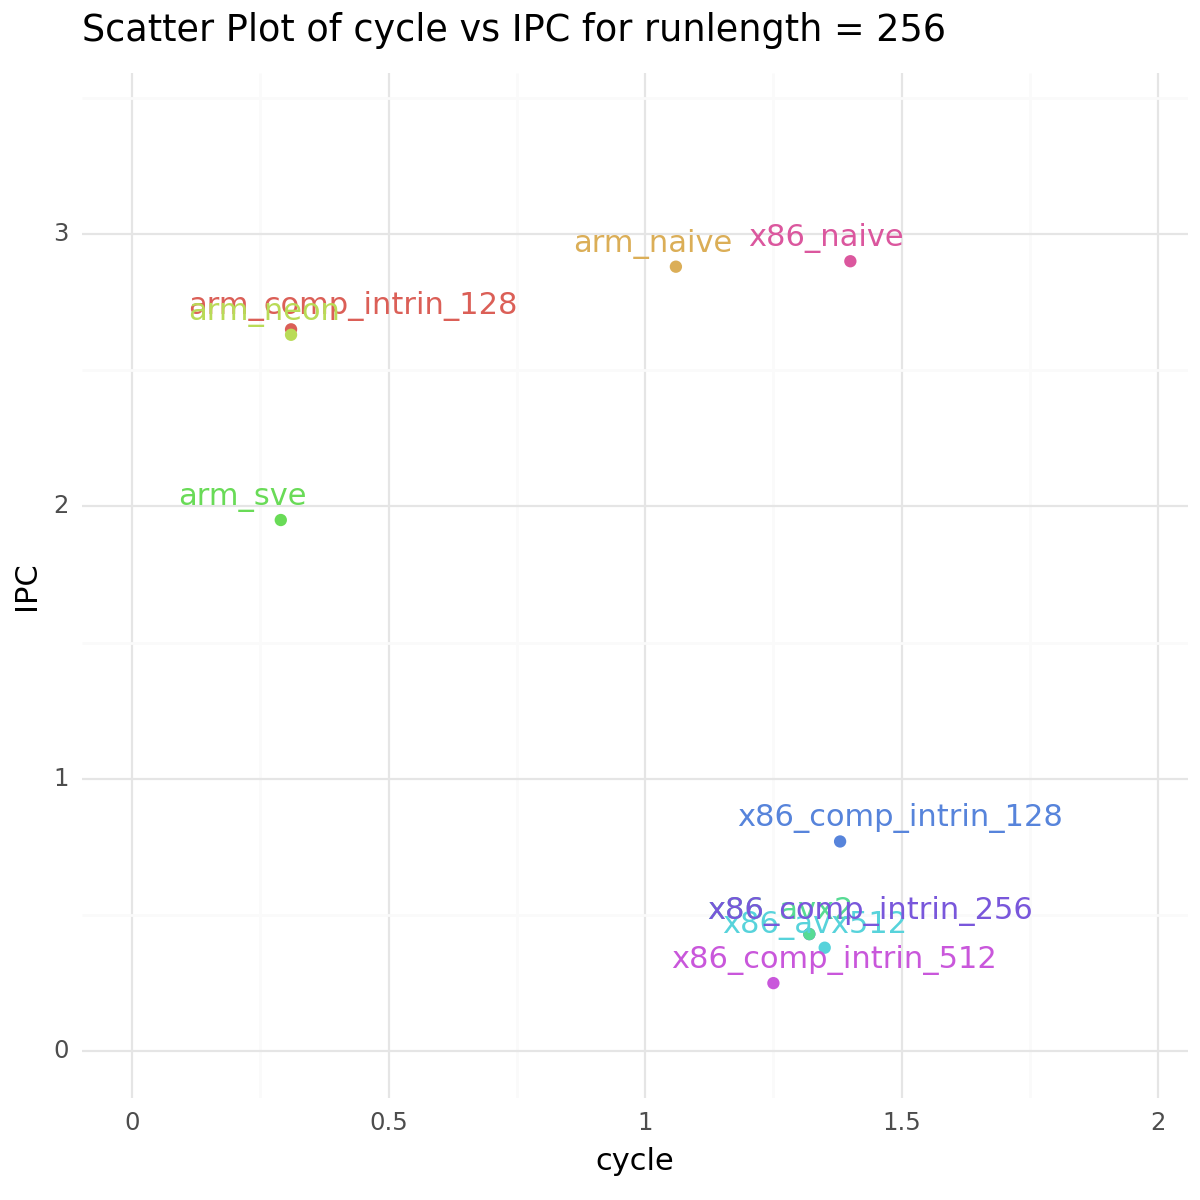

[<Figure Size: (600 x 600)>,
 <Figure Size: (600 x 600)>,
 <Figure Size: (600 x 600)>]

In [50]:
scatter_final_data = grouped_data[(grouped_data['item_size'] == data["item_size"].max())]
scatter_final_data['arch_scheme'] = scatter_final_data['arch'].astype(str) + '_' + scatter_final_data['scheme'].astype(str)


scatter_plots = create_ggplot_scatter_with_labels(scatter_final_data, 'cycle', 'IPC', 'arch_scheme', 'runlength')
scatter_plots